In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    IN_COLAB = False
else:
    drive.mount('/content/drive')
    IN_COLAB = True

In [2]:
if IN_COLAB:
    REF_PATH = "/content/drive/MyDrive/Project/"
else:
    REF_PATH = "../../data/"
REF_PATH += "Average pm25 per neighborhood BASELINE.csv"

In [3]:
TRIPS_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/NYC_Pilot2_PM_Part1.csv'
POLYGON_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/nyc_polygon.geojson'

In [4]:
import pandas as pd
import folium
import geopandas as gpd
from datetime import datetime
import numpy as np
from shapely.geometry import Polygon
import math
import matplotlib.pyplot as plt
from shapely import wkt

import h3

# Neighborhood Approximation

## <font color = 'blue'> Fixed Resolution and Variable Sample Size </font>

### <font color = 'green'>- RMSE </font>

In [5]:
h3_resolution = 8

In [6]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.longitude, trips.latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [7]:
trips['h3'] = trips.apply(lambda x: h3.geo_to_h3(x.latitude, x.longitude, resolution=h3_resolution), axis = 1)

In [8]:
reference_value = pd.read_csv(REF_PATH)
reference_value['geometry'] = reference_value['geometry'].apply(wkt.loads)
reference_value = gpd.GeoDataFrame(reference_value, crs='epsg:4326')
print(reference_value['neighborhood'].nunique())
print(len(reference_value['neighborhood']))

48
48


In [9]:
def calculate_rmse(predicted_values, actual_values):
    # Calculate squared differences
    squared_diff = (predicted_values - actual_values) ** 2
    
    # Calculate mean squared differences
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse

In [10]:
def get_rmse_h3(baseline, encoded):
    error = []
    for sampling_frequency in np.arange(0.1,1.1,0.1):
        sampled_trips = encoded.groupby('h3').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
        df_enc_pm25 = (sampled_trips
                          .groupby('h3')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())  # Make a list of pm25 values for each h3 cell
        df_enc_pm25['average_pm25_value'] = df_enc_pm25['pm25_list'].apply(lambda x:sum(x)/len(x)) #Find the average pm25 value for each h3 cell
        df_enc_pm25.drop('pm25_list', axis = 1, inplace=True)
        sampled_trips_with_neighborhood_pm25 = pd.merge(sampled_trips, baseline, on='neighborhood', how='inner')
        sampled_trips_with_enc_geometry_pm25 = pd.merge(sampled_trips, df_enc_pm25, on='h3', how='inner')
        assert sampled_trips_with_neighborhood_pm25.shape[0] == sampled_trips_with_enc_geometry_pm25.shape[0]
        columns = list(sampled_trips.columns)
        sampled_trips_with_neighborhood_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_neighborhood_pm25.reset_index(drop=True, inplace=True)
        sampled_trips_with_enc_geometry_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_enc_geometry_pm25.reset_index(drop=True, inplace=True)
        baseline_pm25 = sampled_trips_with_neighborhood_pm25["average_pm25_value"].values
        sampled_pm25  = sampled_trips_with_enc_geometry_pm25["average_pm25_value"].values
        rmse = calculate_rmse(sampled_pm25, baseline_pm25)
        error.append(rmse)
    return error

In [11]:
RMSE_H3 = get_rmse_h3(reference_value,trips)

In [12]:
RMSE_H3

[0.2933798189170468,
 0.2959067012385471,
 0.26480652636670443,
 0.27191675601307874,
 0.26788697544057255,
 0.2735249758284826,
 0.27123516794255237,
 0.27076551159782075,
 0.2688675667023005,
 0.2702733646212526]

<Figure size 640x480 with 0 Axes>

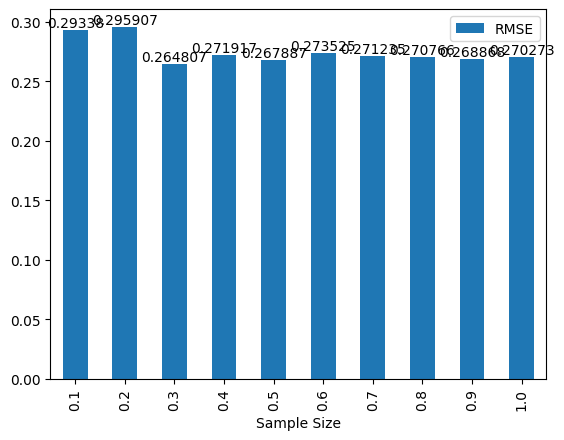

In [13]:
H3_Performance = pd.DataFrame({'Sample Size':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
                               'RMSE': RMSE_H3})
plt.figure()
ax = H3_Performance.plot(kind='bar', x='Sample Size', y= 'RMSE')
ax.bar_label(ax.containers[0], color = 'black')
plt.show()

### <font color = 'green'>- MAPE </font>

In [14]:
h3_resolution = 8

In [15]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.longitude, trips.latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [16]:
trips['h3'] = trips.apply(lambda x: h3.geo_to_h3(x.latitude, x.longitude, resolution=h3_resolution), axis = 1)

In [17]:
reference_value = pd.read_csv(REF_PATH)
reference_value['geometry'] = reference_value['geometry'].apply(wkt.loads)
reference_value = gpd.GeoDataFrame(reference_value, crs='epsg:4326')
print(reference_value['neighborhood'].nunique())
print(len(reference_value['neighborhood']))

48
48


In [18]:
def calculate_mape(predicted_values, actual_values):
    # Calculate absolute differences
    absolute_diff = np.abs(actual_values - predicted_values)
    
    # Calculate percentage error
    percentage_error = absolute_diff / actual_values
    
    # Handle cases where actual values are 0 to avoid division by zero
    percentage_error = np.nan_to_num(percentage_error, nan=0, posinf=0)
    
    # Calculate mean percentage error
    mean_percentage_error = np.mean(percentage_error)
    
    # Convert mean percentage error to percentage
    mape = mean_percentage_error * 100
    
    return mape

In [19]:
def get_mape_h3(baseline, encoded):
    error = []
    for sampling_frequency in np.arange(0.1,1.1,0.1):
        sampled_trips = encoded.groupby('h3').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
        df_enc_pm25 = (sampled_trips
                          .groupby('h3')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())  # Make a list of pm25 values for each h3 cell
        df_enc_pm25['average_pm25_value'] = df_enc_pm25['pm25_list'].apply(lambda x:sum(x)/len(x)) #Find the average pm25 value for each h3 cell
        df_enc_pm25.drop('pm25_list', axis = 1, inplace=True)
        sampled_trips_with_neighborhood_pm25 = pd.merge(sampled_trips, baseline, on='neighborhood', how='inner')
        sampled_trips_with_enc_geometry_pm25 = pd.merge(sampled_trips, df_enc_pm25, on='h3', how='inner')
        assert sampled_trips_with_neighborhood_pm25.shape[0] == sampled_trips_with_enc_geometry_pm25.shape[0]
        columns = list(sampled_trips.columns)
        sampled_trips_with_neighborhood_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_neighborhood_pm25.reset_index(drop=True, inplace=True)
        sampled_trips_with_enc_geometry_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_enc_geometry_pm25.reset_index(drop=True, inplace=True)
        baseline_pm25 = sampled_trips_with_neighborhood_pm25["average_pm25_value"].values
        sampled_pm25  = sampled_trips_with_enc_geometry_pm25["average_pm25_value"].values
        mape = calculate_mape(sampled_pm25, baseline_pm25)
        error.append(mape)
    return error

In [20]:
MAPE_H3 = get_mape_h3(reference_value,trips)

In [21]:
MAPE_H3

[3.7254915884222224,
 3.626558468562092,
 3.3778520383762562,
 3.3801759067048227,
 3.4782903287663847,
 3.447862590181161,
 3.4685655632890553,
 3.4087035083673785,
 3.3679591019758712,
 3.3859417224106703]

<Figure size 640x480 with 0 Axes>

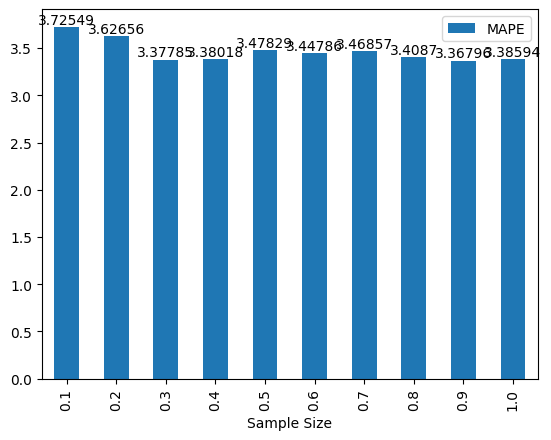

In [22]:
H3_Performance = pd.DataFrame({'Sample Size':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
                               'MAPE': MAPE_H3})
plt.figure()
ax = H3_Performance.plot(kind='bar', x='Sample Size', y= 'MAPE')
ax.bar_label(ax.containers[0], color = 'black')
plt.show()

## <font color = 'blue'> Fixed Sample Size and Variable Resolution </font>

### <font color = 'green'>- RMSE </font>

In [23]:
h3_resolution_min = 0
h3_resolution_max = 15
sampling_frequency = 0.6

In [24]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.longitude, trips.latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [25]:
reference_value = pd.read_csv(REF_PATH)
reference_value['geometry'] = reference_value['geometry'].apply(wkt.loads)
reference_value = gpd.GeoDataFrame(reference_value, crs='epsg:4326')
print(reference_value['neighborhood'].nunique())
print(len(reference_value['neighborhood']))

48
48


In [26]:
def calculate_rmse(predicted_values, actual_values):
    # Calculate squared differences
    squared_diff = (predicted_values - actual_values) ** 2
    
    # Calculate mean squared differences
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse

In [27]:
def group_by_h3(df, h3_resolution):
    df['h3'] = df.apply(lambda x: h3.geo_to_h3(x.latitude, x.longitude, resolution=h3_resolution), axis=1)
    return df.groupby('h3')

In [28]:
def get_rmse_h3(baseline, encoded):
    error = []
    h3_resolution = h3_resolution_min
    while h3_resolution <= h3_resolution_max:
        sampled_trips = group_by_h3(encoded, h3_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
        df_enc_pm25 = (sampled_trips
                          .groupby('h3')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())  # Make a list of pm25 values for each h3 cell
        df_enc_pm25['average_pm25_value'] = df_enc_pm25['pm25_list'].apply(lambda x:sum(x)/len(x)) #Find the average pm25 value for each h3 cell
        df_enc_pm25.drop('pm25_list', axis = 1, inplace=True)
        sampled_trips_with_neighborhood_pm25 = pd.merge(sampled_trips, baseline, on='neighborhood', how='inner')
        sampled_trips_with_enc_geometry_pm25 = pd.merge(sampled_trips, df_enc_pm25, on='h3', how='inner')
        assert sampled_trips_with_neighborhood_pm25.shape[0] == sampled_trips_with_enc_geometry_pm25.shape[0]
        columns = list(sampled_trips.columns)
        sampled_trips_with_neighborhood_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_neighborhood_pm25.reset_index(drop=True, inplace=True)
        sampled_trips_with_enc_geometry_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_enc_geometry_pm25.reset_index(drop=True, inplace=True)
        baseline_pm25 = sampled_trips_with_neighborhood_pm25["average_pm25_value"].values
        sampled_pm25  = sampled_trips_with_enc_geometry_pm25["average_pm25_value"].values
        rmse = calculate_rmse(sampled_pm25, baseline_pm25)
        error.append(rmse) #Append to Error list
        h3_resolution += 1
    return error

In [29]:
RMSE_H3 = get_rmse_h3(reference_value,trips)

In [30]:
RMSE_H3

[0.4146001799947047,
 0.4137301873824612,
 0.4110776514977869,
 0.40893145546631704,
 0.4030768353838914,
 0.39206487723487754,
 0.2902957606990316,
 0.2744760962011503,
 0.2714282333090266,
 0.38739015772033636,
 0.6343371408051118,
 0.8391556547349501,
 1.1021157351405104,
 1.374813457113562,
 1.5668555251698513,
 1.666059961322447]

<Figure size 640x480 with 0 Axes>

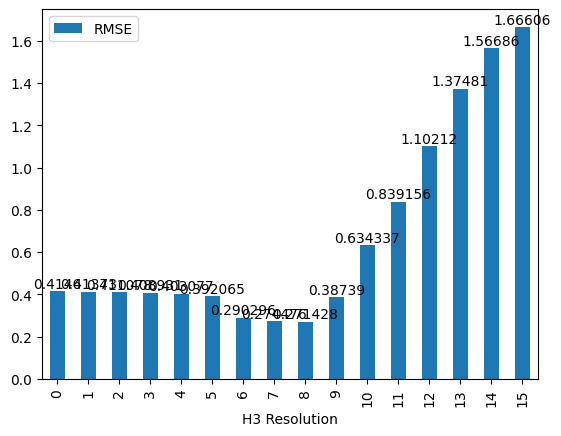

In [31]:
X_LABEL = 'H3 Resolution'
Y_LABEL = 'RMSE'
H3_Performance = pd.DataFrame({X_LABEL:list(range(h3_resolution_min, h3_resolution_max + 1)),
                               Y_LABEL: RMSE_H3})
plt.figure()
ax = H3_Performance.plot(kind='bar', x=X_LABEL, y=Y_LABEL)
ax.bar_label(ax.containers[0], color = 'black')
plt.show()

### <font color = 'green'>- MAPE </font>

In [32]:
h3_resolution_min = 0
h3_resolution_max = 15
sampling_frequency = 0.6

In [33]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.longitude, trips.latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [34]:
reference_value = pd.read_csv(REF_PATH)
reference_value['geometry'] = reference_value['geometry'].apply(wkt.loads)
reference_value = gpd.GeoDataFrame(reference_value, crs='epsg:4326')
print(reference_value['neighborhood'].nunique())
print(len(reference_value['neighborhood']))

48
48


In [35]:
def calculate_mape(predicted_values, actual_values):
    # Calculate absolute differences
    absolute_diff = np.abs(actual_values - predicted_values)
    
    # Calculate percentage error
    percentage_error = absolute_diff / actual_values
    
    # Handle cases where actual values are 0 to avoid division by zero
    percentage_error = np.nan_to_num(percentage_error, nan=0, posinf=0)
    
    # Calculate mean percentage error
    mean_percentage_error = np.mean(percentage_error)
    
    # Convert mean percentage error to percentage
    mape = mean_percentage_error * 100
    
    return mape

In [36]:
def group_by_h3(df, h3_resolution):
    df['h3'] = df.apply(lambda x: h3.geo_to_h3(x.latitude, x.longitude, resolution=h3_resolution), axis=1)
    return df.groupby('h3')

In [37]:
def get_mape_h3(baseline, encoded):
    error = []
    h3_resolution = h3_resolution_min
    while h3_resolution <= h3_resolution_max:
        sampled_trips = group_by_h3(encoded, h3_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
        df_enc_pm25 = (sampled_trips
                          .groupby('h3')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())  # Make a list of pm25 values for each h3 cell
        df_enc_pm25['average_pm25_value'] = df_enc_pm25['pm25_list'].apply(lambda x:sum(x)/len(x)) #Find the average pm25 value for each h3 cell
        df_enc_pm25.drop('pm25_list', axis = 1, inplace=True)
        sampled_trips_with_neighborhood_pm25 = pd.merge(sampled_trips, baseline, on='neighborhood', how='inner')
        sampled_trips_with_enc_geometry_pm25 = pd.merge(sampled_trips, df_enc_pm25, on='h3', how='inner')
        assert sampled_trips_with_neighborhood_pm25.shape[0] == sampled_trips_with_enc_geometry_pm25.shape[0]
        columns = list(sampled_trips.columns)
        sampled_trips_with_neighborhood_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_neighborhood_pm25.reset_index(drop=True, inplace=True)
        sampled_trips_with_enc_geometry_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_enc_geometry_pm25.reset_index(drop=True, inplace=True)
        baseline_pm25 = sampled_trips_with_neighborhood_pm25["average_pm25_value"].values
        sampled_pm25  = sampled_trips_with_enc_geometry_pm25["average_pm25_value"].values
        mape = calculate_mape(sampled_pm25, baseline_pm25)
        error.append(mape) #Append to Error list
        h3_resolution += 1
    return error

In [38]:
MAPE_H3 = get_mape_h3(reference_value,trips)

In [39]:
MAPE_H3

[3.413662911832691,
 3.4617647106858045,
 3.3702167832257803,
 3.4244631064275657,
 3.439777122899453,
 3.262689598093053,
 2.7213044198386176,
 2.7307880973983583,
 3.385393017636583,
 6.091943732302356,
 9.240605488240941,
 11.838091812013765,
 16.44712844968213,
 20.594051300964306,
 23.997374570146178,
 25.9718837395714]

<Figure size 640x480 with 0 Axes>

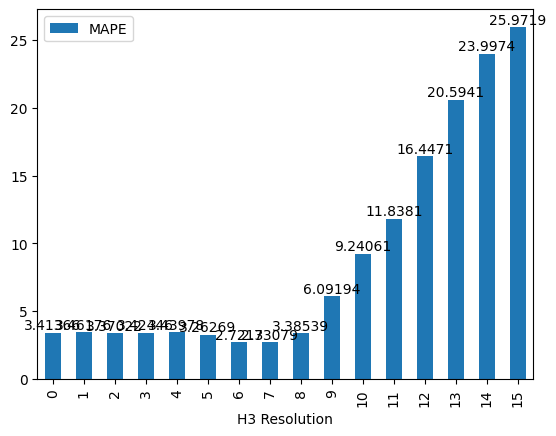

In [40]:
X_LABEL = 'H3 Resolution'
Y_LABEL = 'MAPE'
H3_Performance = pd.DataFrame({X_LABEL:list(range(h3_resolution_min, h3_resolution_max + 1)),
                               Y_LABEL: MAPE_H3})
plt.figure()
ax = H3_Performance.plot(kind='bar', x=X_LABEL, y=Y_LABEL)
ax.bar_label(ax.containers[0], color = 'black')
plt.show()

# Stratified Sampling

## <font color = 'blue'> Fixed Resolution and Variable Sample Size </font>

### <font color = 'green'>- RMSE </font>

In [41]:
h3_resolution = 8

In [42]:
def calculate_rmse(predicted_values, actual_values):
    # Calculate squared differences
    squared_diff = (predicted_values - actual_values) ** 2
    
    # Calculate mean squared differences
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse

In [43]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.longitude, trips.latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [44]:
trips['h3'] = trips.apply(lambda x: h3.geo_to_h3(x.latitude, x.longitude, resolution=h3_resolution), axis = 1)

In [45]:
population_pm25 = (trips
                .groupby('neighborhood')
                .pm25
                .agg(list)
                .to_frame("pm25_list")
                .reset_index())  # Make a list of pm25 values for each neighborhood

population_pm25['average_pm25_value'] = population_pm25['pm25_list'].apply(lambda x: sum(x) / len(x))  # Find the average pm25 value per neighborhood
population_pm25.drop('pm25_list', axis = 1, inplace=True)

population_pm25.sort_values(by='neighborhood', inplace=True)
population_pm25.reset_index(drop=True, inplace=True)

In [46]:
def perform_test():
    error = []
    sample_size_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for sampling_frequency in sample_size_range:
        stratified_sample = trips.groupby('h3').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
        random_sample_pm25 = (stratified_sample
                    .groupby('neighborhood')
                    .pm25
                    .agg(list)
                    .to_frame("pm25_list")
                    .reset_index())  # Make a list of pm25 values for each neighborhood
        random_sample_pm25['average_pm25_value'] = random_sample_pm25['pm25_list'].apply(lambda x: sum(x) / len(x))  # Find the average pm25 value per neighborhood
        random_sample_pm25.drop('pm25_list', axis = 1, inplace=True)
        for neighborhood in population_pm25["neighborhood"]:
            if neighborhood not in random_sample_pm25["neighborhood"].values:
                random_sample_pm25.loc[len(random_sample_pm25.index)] = [neighborhood, 0]
        random_sample_pm25.sort_values(by='neighborhood', inplace=True)
        random_sample_pm25.reset_index(drop=True, inplace=True)
        assert population_pm25['neighborhood'].equals(random_sample_pm25['neighborhood'])
        baseline_pm25 =    population_pm25["average_pm25_value"].values
        sampled_pm25  = random_sample_pm25["average_pm25_value"].values
        rmse = calculate_rmse(sampled_pm25, baseline_pm25)
        error.append(rmse)
    H3_Performance = pd.DataFrame({'Sample Size': sample_size_range,
                                'RMSE': error})
    plt.figure()
    ax = H3_Performance.plot(kind='bar', x='Sample Size', y= 'RMSE')
    ax.bar_label(ax.containers[0], color = 'black')
    plt.show()

<Figure size 640x480 with 0 Axes>

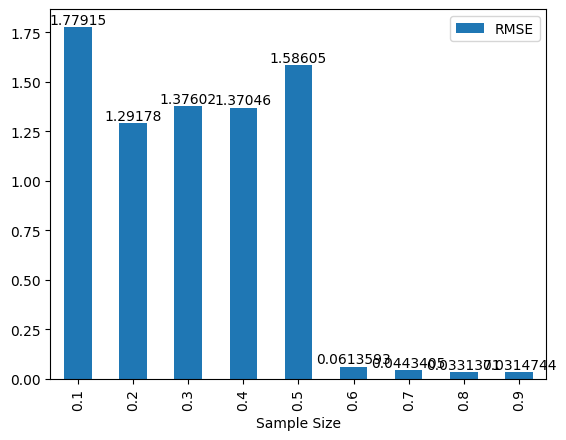

<Figure size 640x480 with 0 Axes>

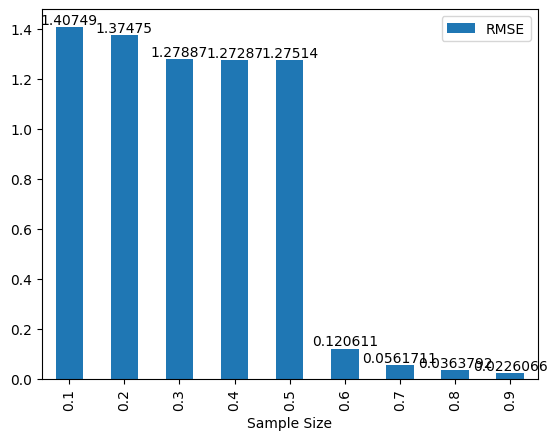

<Figure size 640x480 with 0 Axes>

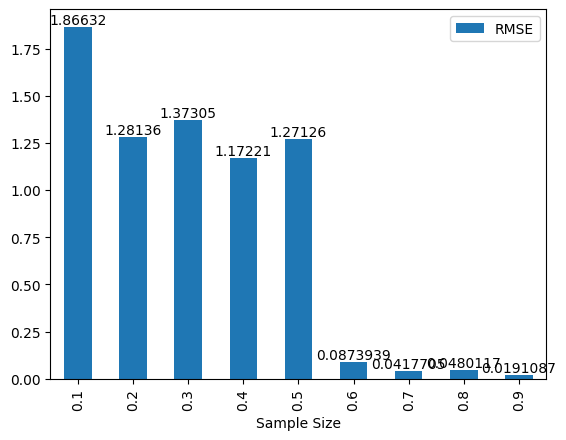

<Figure size 640x480 with 0 Axes>

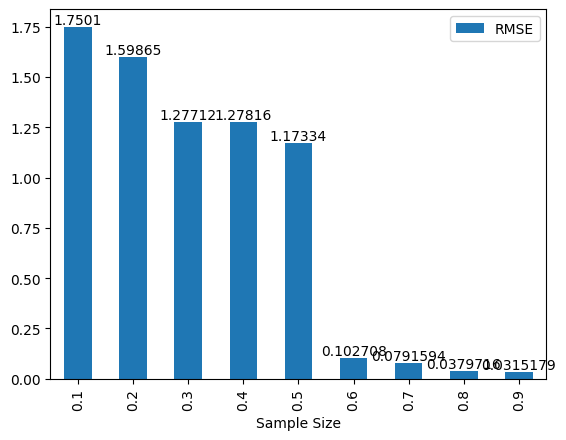

<Figure size 640x480 with 0 Axes>

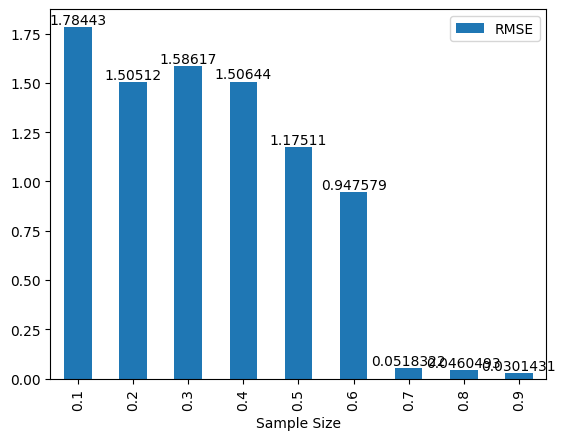

In [47]:
for _ in range(5):
    perform_test()

We see that when the H3 resolution is fixed to 8 and starting from sample size 60%, stratified sampling using H3 is reliable when it comes to reducing the dataset size while still retaining the same information on a neighborhood-level. (With very minor fluctuations in sample size 60%.)

## <font color = 'blue'> Fixed Sample Size and Variable Resolution </font>

### <font color = 'green'>- RMSE </font>

In [48]:
h3_resolution_min = 0
h3_resolution_max = 15
sampling_frequency = 0.6

In [49]:
def calculate_rmse(predicted_values, actual_values):
    # Calculate squared differences
    squared_diff = (predicted_values - actual_values) ** 2
    
    # Calculate mean squared differences
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse

In [50]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.longitude, trips.latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [51]:
population_pm25 = (trips
                .groupby('neighborhood')
                .pm25
                .agg(list)
                .to_frame("pm25_list")
                .reset_index())  # Make a list of pm25 values for each neighborhood

population_pm25['average_pm25_value'] = population_pm25['pm25_list'].apply(lambda x: sum(x) / len(x))  # Find the average pm25 value per neighborhood
population_pm25.drop('pm25_list', axis = 1, inplace=True)

population_pm25.sort_values(by='neighborhood', inplace=True)
population_pm25.reset_index(drop=True, inplace=True)

In [52]:
def group_by_h3(df, h3_resolution):
    df['h3'] = df.apply(lambda x: h3.geo_to_h3(x.latitude, x.longitude, resolution=h3_resolution), axis=1)
    return df.groupby('h3')

In [53]:
def perform_test():
    error = []
    h3_resolution = h3_resolution_min
    while h3_resolution <= h3_resolution_max:
        stratified_sample = group_by_h3(trips, h3_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
        random_sample_pm25 = (stratified_sample
                    .groupby('neighborhood')
                    .pm25
                    .agg(list)
                    .to_frame("pm25_list")
                    .reset_index())  # Make a list of pm25 values for each neighborhood
        random_sample_pm25['average_pm25_value'] = random_sample_pm25['pm25_list'].apply(lambda x: sum(x) / len(x))  # Find the average pm25 value per neighborhood
        random_sample_pm25.drop('pm25_list', axis = 1, inplace=True)
        for neighborhood in population_pm25["neighborhood"]:
            if neighborhood not in random_sample_pm25["neighborhood"].values:
                random_sample_pm25.loc[len(random_sample_pm25.index)] = [neighborhood, 0]
        random_sample_pm25.sort_values(by='neighborhood', inplace=True)
        random_sample_pm25.reset_index(drop=True, inplace=True)
        assert population_pm25['neighborhood'].equals(random_sample_pm25['neighborhood'])
        baseline_pm25 =    population_pm25["average_pm25_value"].values
        sampled_pm25  = random_sample_pm25["average_pm25_value"].values
        rmse = calculate_rmse(sampled_pm25, baseline_pm25)
        error.append(rmse)
        h3_resolution += 1
    H3_Performance = pd.DataFrame({'H3 Resolution':list(range(h3_resolution_min, h3_resolution_max + 1)),
                                'RMSE': error})
    plt.figure()
    ax = H3_Performance.plot(kind='bar', x='H3 Resolution', y= 'RMSE')
    ax.bar_label(ax.containers[0], color = 'black')
    plt.show()

<Figure size 640x480 with 0 Axes>

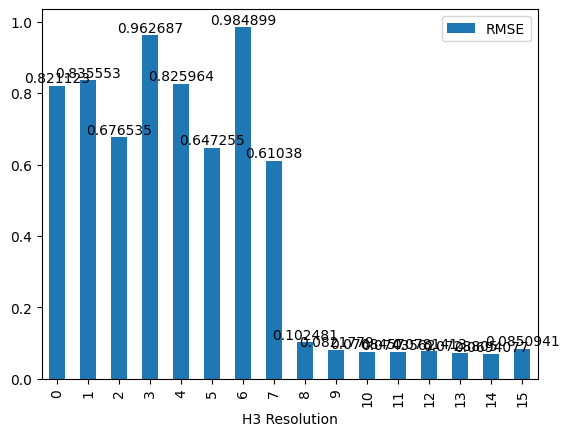

<Figure size 640x480 with 0 Axes>

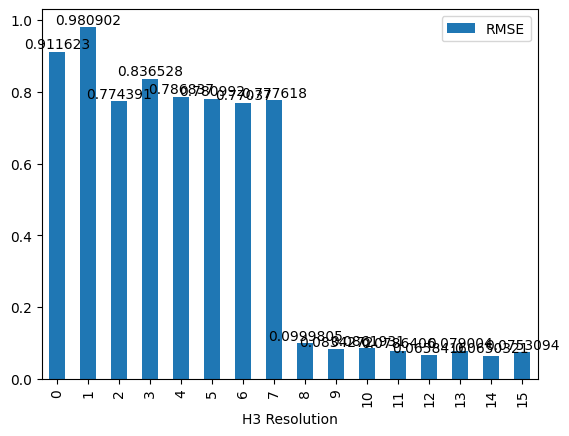

<Figure size 640x480 with 0 Axes>

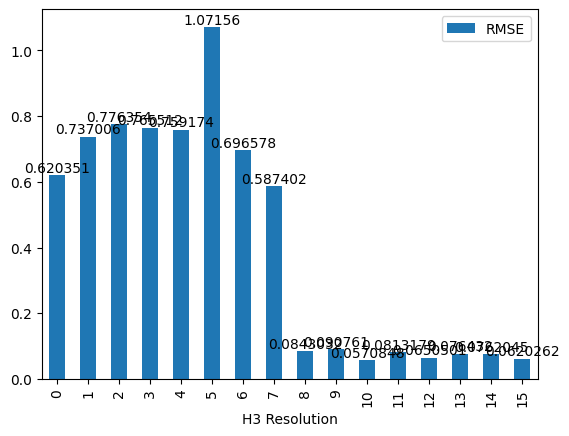

<Figure size 640x480 with 0 Axes>

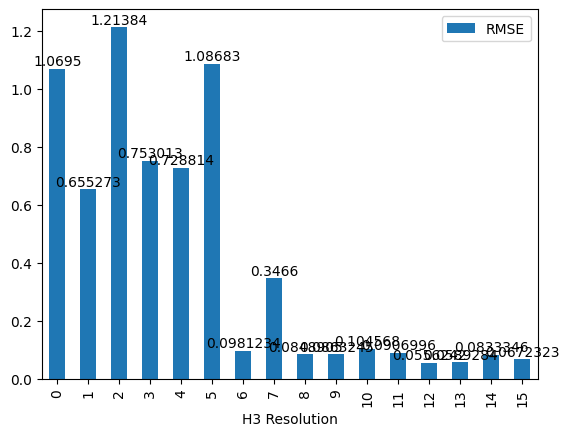

<Figure size 640x480 with 0 Axes>

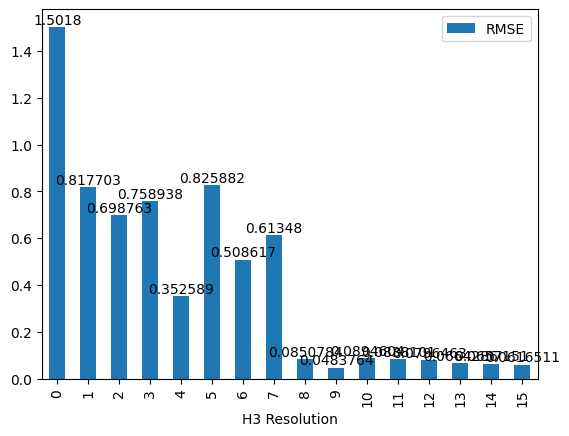

In [54]:
for _ in range(5):
    perform_test()

We see that with H3 resolutions >= 8, 60% is a good sample size to use for stratified sampling using H3 when it comes to reducing the dataset size while still retaining the same information on a neighborhood-level.